In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scirpy as ir
from pathlib import Path
from dateutil import parser
from datetime import datetime

warnings.filterwarnings('ignore', category=FutureWarning)

plt.rcParams.update({'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'})

# Benchmark tcr_dist

 * The performance of `tcr_dist`, the function computing the alignment-distances, is limited by the number of unique TCR-alpha and -beta sequences
 * The function is in $O(n^2)$, where $n$ is the number of unique sequences

In [2]:
adata = ir.datasets.wu2020()
adata = adata[adata.obs["has_tcr"] == "True", :]

In [3]:
print(f"Number of unique alpha sequences: {adata.obs['TRA_1_cdr3'].unique().size}")
print(f"Fraction of unique alpha sequences: {adata.obs['TRA_1_cdr3'].unique().size / adata.shape[0]:.2f}")
print(f"Number of unique beta sequences: {adata.obs['TRB_1_cdr3'].unique().size}")
print(f"Fraction of unique beta sequences: {adata.obs['TRB_1_cdr3'].unique().size/adata.shape[0]:.2f}")

Number of unique alpha sequences: 29905
Fraction of unique alpha sequences: 0.31
Number of unique beta sequences: 42668
Fraction of unique beta sequences: 0.44


 * -> We could expect a dataset of ~1M cells to have between 300k and 500k unique sequences
 * In the benchmark, we tested up to 300k unique sequences
 * Each dataset was ran on 16 cores on an Intel E5-2699A v4, 2.4 GHz CPU

 * parse the results from the `/usr/bin/time` command. 

In [4]:
results = Path("../results/02_tcr_dist")
perf = dict()
for f in results.glob("timing_mem_*.txt"):
    n = int(f.stem.split("_")[2])
    perf[n] = dict()
    with open(f, 'r') as fh:
        for l in fh.readlines():
            if "Elapsed (wall clock) time" in l:
                time_str = l.split(': ')[1].strip().split(".")[0]
                try:
                    perf[n]["wall_time"] = datetime.strptime(time_str, "%M:%S")
                except ValueError:
                    perf[n]["wall_time"] = datetime.strptime(time_str, "%H:%M:%S")

In [5]:
def get_time(dt):
    """in hours"""
    return (dt.hour * 3600 + dt.minute * 60 + dt.second) / 3600

In [6]:
ns = sorted(perf.keys())
ns

[3000, 5000, 10000, 20000, 50000, 100000, 200000, 300000]

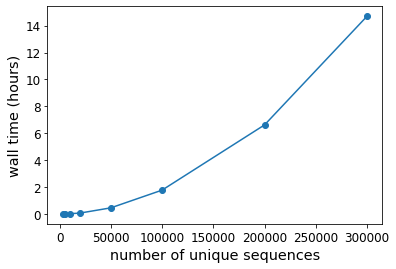

In [7]:
fig, ax = plt.subplots()
ax.plot(ns, [get_time(perf[n]["wall_time"]) for n in ns], 'o-')
ax.set_xlabel("number of unique sequences")
ax.set_ylabel("wall time (hours)")
fig.savefig("../../figures/runtime_tcr_dist.svg")

In [8]:
results = Path("../results/04_tcr_neighbors")
perf = dict()
for f in results.glob("timing_mem_adata_*.txt"):
    n = int(f.stem.split("_")[3])
    perf[n] = dict()
    with open(f, 'r') as fh:
        for l in fh.readlines():
            if "Elapsed (wall clock) time" in l:
                time_str = l.split(': ')[1].strip().split(".")[0]
                try:
                    perf[n]["wall_time"] = datetime.strptime(time_str, "%M:%S")
                except ValueError:
                    perf[n]["wall_time"] = datetime.strptime(time_str, "%H:%M:%S")

In [9]:
ns = sorted(perf.keys())
ns

[16553,
 32486,
 87971,
 176328,
 263417,
 282036,
 359250,
 445343,
 541091,
 632003,
 724978,
 816137,
 907699,
 996648,
 1085999]

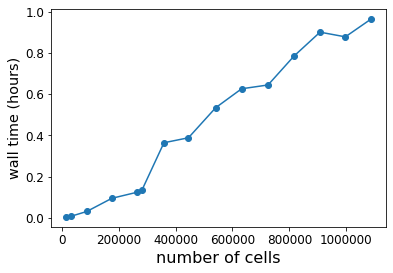

In [10]:
fig, ax = plt.subplots()
ax.plot(ns, [get_time(perf[n]["wall_time"]) for n in ns], 'o-')
ax.set_xlabel("number of cells", fontsize=16)
ax.set_ylabel("wall time (hours)")
ax.ticklabel_format(style='plain')
fig.savefig("../../figures/runtime_tcr_neighbors.svg")